In [ ]:
#!pip install bayesian-optimization
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time

from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

from bayes_opt import BayesianOptimization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/My Drive/Case/Repeat Buyers Prediction/data/train.csv',index_col=0)
test = pd.read_csv('/content/drive/My Drive/Case/Repeat Buyers Prediction/data/test.csv',index_col=0)

In [ ]:
print('train dataset has {} rows and {} columns.'.format(train.shape[0],train.shape[1]))
print('test dataset has {} rows and {} columns.'.format(test.shape[0],test.shape[1]))

train dataset has 260864 rows and 135 columns.
test dataset has 261477 rows and 134 columns.


In [ ]:
#userInfo = pd.read_csv('/content/drive/My Drive/Case/Repeat Buyers Prediction/data/user_info_format1.csv')
#train = train.join(userInfo.set_index('user_id'), how='left', on='user_id')
#test = test.join(userInfo.set_index('user_id'), how='left', on='user_id')
#del userInfo

In [ ]:
train['age_range'] = train['age_range'].astype('category')
train['gender'] = train['gender'].astype('category')
test['age_range'] = test['age_range'].astype('category')
test['gender'] = test['gender'].astype('category')

In [ ]:
categorical_feats = ['gender','age_range']
#train = pd.get_dummies(train)
#test = pd.get_dummies(test)

# Feature Selection with Null Importance

Create a scoring function (By Olivier)

In [ ]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['user_id','merchant_id','label']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['label'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['label'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [ ]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=train, shuffle=False)

In [ ]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,user_interact_count,4699.225058,180,0.689092
1,user_click_count,5551.467224,205,0.689092
2,user_cart_count,264.421099,12,0.689092
3,user_purchase_count,26236.534552,947,0.689092
4,user_favourite_count,4756.171493,179,0.689092


Build Null Importances distribution

In [ ]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with    1 of   80 (Spent   0.5 min)Done with    2 of   80 (Spent   1.0 min)Done with    3 of   80 (Spent   1.6 min)Done with    4 of   80 (Spent   2.2 min)Done with    5 of   80 (Spent   2.9 min)Done with    6 of   80 (Spent   3.3 min)Done with    7 of   80 (Spent   3.9 min)Done with    8 of   80 (Spent   4.5 min)Done with    9 of   80 (Spent   5.0 min)Done with   10 of   80 (Spent   5.5 min)Done with   11 of   80 (Spent   6.0 min)Done with   12 of   80 (Spent   6.6 min)Done with   13 of   80 (Spent   7.2 min)

In [ ]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,user_interact_count,1967.380791,503,0.688987,1
1,user_click_count,1645.552336,316,0.688987,1
2,user_cart_count,508.772747,59,0.688987,1
3,user_purchase_count,2286.879136,302,0.688987,1
4,user_favourite_count,1990.119206,233,0.688987,1


Score features

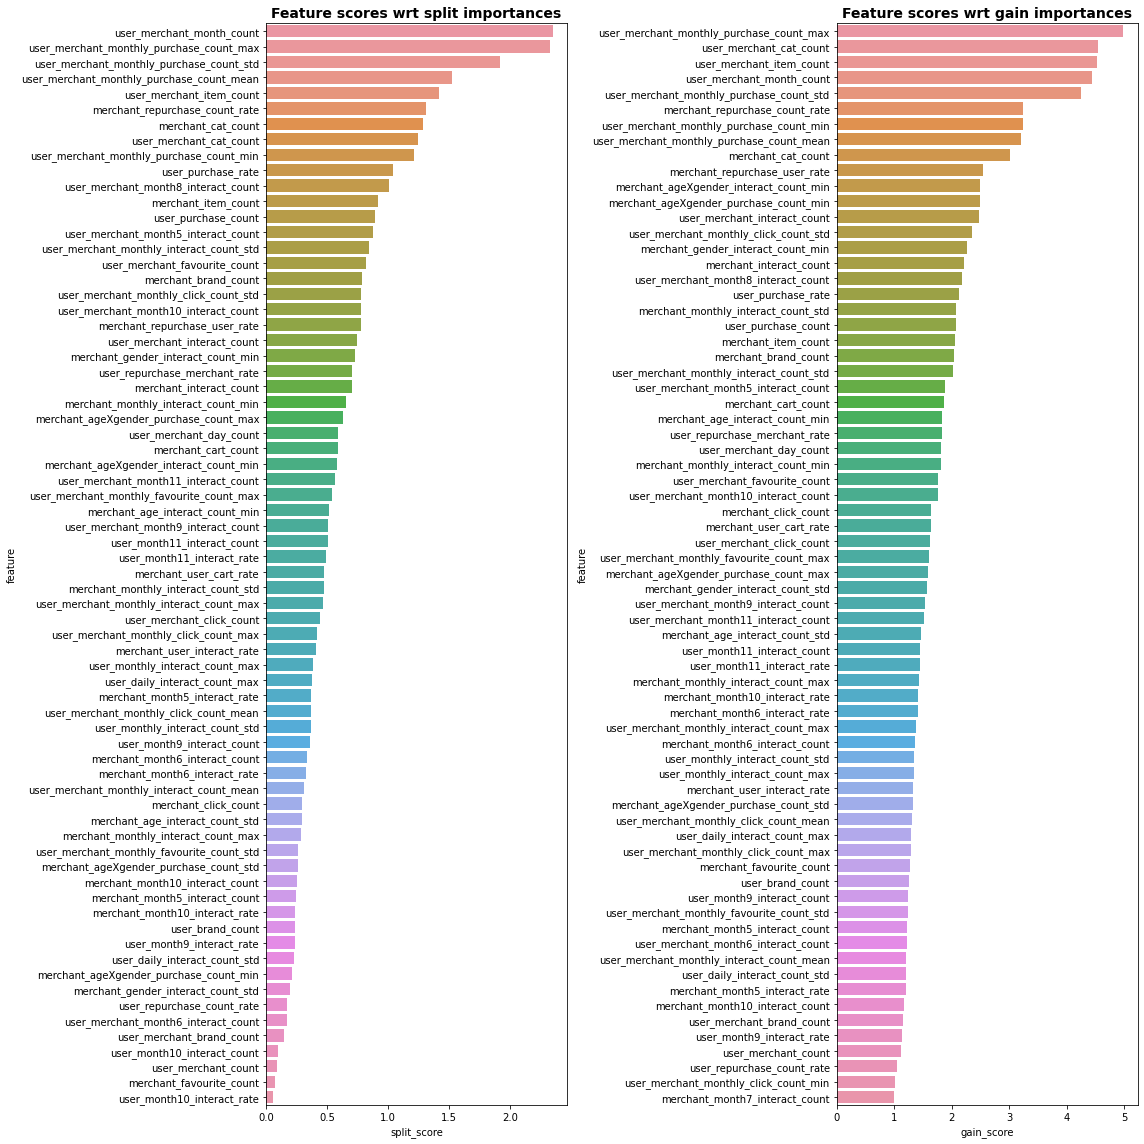

In [ ]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()


Check the impact of removing uncorrelated features

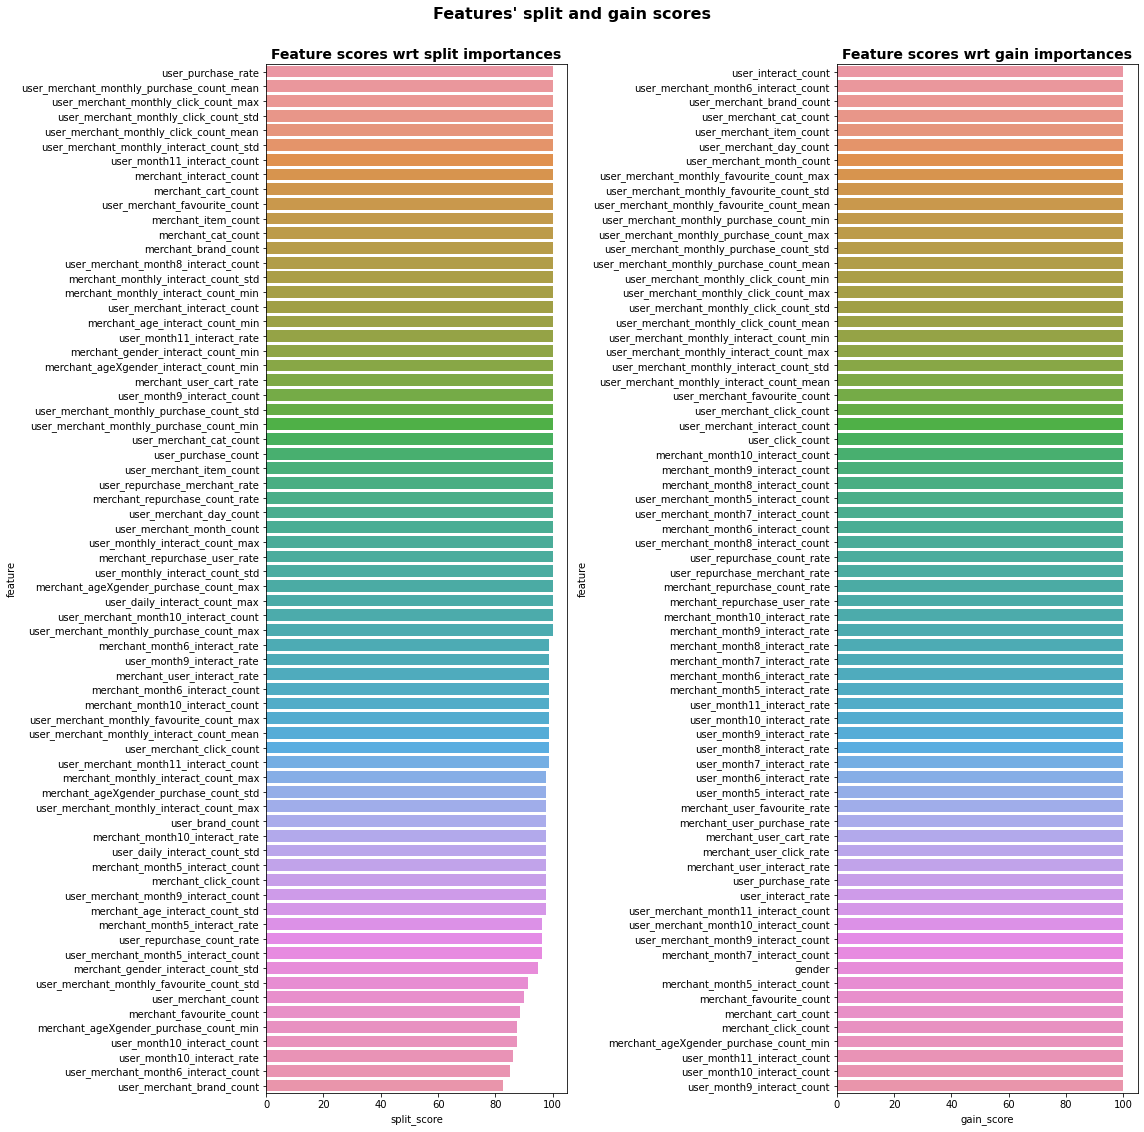

In [ ]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds

In [ ]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=train, train_features=split_feats, cat_feats=split_cat_feats, target=train['label'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=train, train_features=gain_feats, cat_feats=gain_cat_feats, target=train['label'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
	 SPLIT : 0.680842 +/- 0.005934
	 GAIN  : 0.680842 +/- 0.005934
Results for threshold  10
	 SPLIT : 0.680767 +/- 0.007494
	 GAIN  : 0.680942 +/- 0.006197
Results for threshold  20
	 SPLIT : 0.680321 +/- 0.006994
	 GAIN  : 0.680919 +/- 0.006117
Results for threshold  30
	 SPLIT : 0.680179 +/- 0.007774
	 GAIN  : 0.680585 +/- 0.005916
Results for threshold  40
	 SPLIT : 0.680086 +/- 0.007223
	 GAIN  : 0.680585 +/- 0.005916
Results for threshold  50
	 SPLIT : 0.680354 +/- 0.007034
	 GAIN  : 0.680585 +/- 0.005916
Results for threshold  60
	 SPLIT : 0.680309 +/- 0.007410
	 GAIN  : 0.680436 +/- 0.007670
Results for threshold  70
	 SPLIT : 0.680050 +/- 0.007241
	 GAIN  : 0.680622 +/- 0.006671
Results for threshold  80
	 SPLIT : 0.680391 +/- 0.006995
	 GAIN  : 0.680622 +/- 0.006671
Results for threshold  90
	 SPLIT : 0.679992 +/- 0.007356
	 GAIN  : 0.680443 +/- 0.006387
Results for threshold  95
	 SPLIT : 0.681529 +/- 0.007019
	 GAIN  : 0.680938 +/- 0.006140
Results fo

In [ ]:
gain_feats = [_f for _f, _, _score in correlation_scores if _score >= 95]
print(len(gain_feats))

116


# Bayesian Optimization

In [ ]:
#features = [x for x in train.columns if x not in['user_id','merchant_id','label']]
features = gain_feats
X = train[features]
y = train['label']
X_test = test[features]
del train, test

categorical_feats = ['gender']

In [ ]:
def bayes_parameter_opt_lgb(X,y,init_round=15,opt_round=25,n_folds=5,random_seed=0,
              n_estimators=10000,learning_rate=0.02,output_process=False):
  # Prepare data
  train_data = lgb.Dataset(data=X,label=y,free_raw_data=False)

  # Parameters
  def lgb_eval(num_leaves,max_depth,lambda_l1,lambda_l2,min_split_gain,min_child_weight):
    params={'application':'binary','num_iterations':n_estimators,'learning_rate':learning_rate,
            'early_stopping_round':200,'metric':'roc'}
    params['nthread'] = 4
    params['num_leaves'] = int(round(num_leaves))
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1,0)
    params['lambda_l2'] = max(lambda_l2,0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params['silent'] = -1
    params['verbose'] = -1
    cv_result=lgb.cv(params,train_data,nfold=n_folds,seed=random_seed,verbose_eval=200,
                     metrics=['auc'],categorical_feature=categorical_feats)
    return max(cv_result['auc-mean'])
    
  # Range
  lgbBO = BayesianOptimization(lgb_eval,{'num_leaves':(24,45),
                        'max_depth':(5,45),
                        'lambda_l1':(0,5),
                        'lambda_l2':(0,3),
                        'min_split_gain':(0.001,0.1),
                        'min_child_weight':(5,50)},random_state=0)
  # Optimize
  lgbBO.maximize(init_points=init_round,n_iter=opt_round)

  # Output optimization process
  #if output_process == True: lgbBO.points_to_csv('/content/drive/My Drive/Case/Repeat Buyers Prediction/data/bayes_opt_result.csv')
  # Return best parameters
  return lgbBO.max['params']

lgb_opt_params = bayes_parameter_opt_lgb(X,y,init_round=5,opt_round=10,n_folds=5,random_seed=0,
                                  n_estimators=10000,learning_rate=0.02)
lgb_opt_params

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
[200]	cv_agg's auc: 0.680736 + 0.00453402
[400]	cv_agg's auc: 0.686272 + 0.00481912
[600]	cv_agg's auc: 0.686701 + 0.00502921
[800]	cv_agg's auc: 0.686576 + 0.00493846
|  1        |  0.6869   |  2.744    |  2.146    |  29.11    |  29.52    |  0.04294  |  37.56    |
[200]	cv_agg's auc: 0.679736 + 0.00463295
[400]	cv_agg's auc: 0.685408 + 0.00459969
[600]	cv_agg's auc: 0.686169 + 0.00511302
[800]	cv_agg's auc: 0.686033 + 0.0054654
|  2        |  0.6863   |  2.188    |  2.675    |  43.55    |  22.25    |  0.07938  |  35.11    |
[200]	cv_agg's auc: 0.679853 + 0.00511911
[400]	cv_agg's auc: 0.685086 + 0.00527352
[600]	cv_agg's auc: 0.685799 + 0.0053908
[800]	cv_agg's auc: 0.685942 + 0.00548985
|  3        |  0.6861   |  2.84     |  2.777    |  7.841    |  8.921    |  0.003002 |  41.49    |
[400]	cv

{'lambda_l1': 0.4707675379863746,
 'lambda_l2': 2.1987971627276868,
 'max_depth': 44.87342712725129,
 'min_child_weight': 48.29016235523143,
 'min_split_gain': 0.03863107467291655,
 'num_leaves': 24.436376162887104}

# LGBM on KFold

In [ ]:
params = {
    'boost': 'gbdt',
    'learning_rate': 0.02,
    'max_depth': 45,
    'metric':'auc',
    'num_leaves': 24,
    'num_threads': 4,
    'objective': 'binary'
}

In [ ]:
num_folds = 5
features = gain_feats

folds = KFold(n_splits=num_folds, random_state=1234)
oof = np.zeros(len(X))
getVal = np.zeros(len(X))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

#params={'application':'binary','num_iterations':10000,'learning_rate':0.02,
#            'metric':'roc'}
#params['nthread'] = 4
#params['num_leaves'] = int(round(lgb_opt_params['num_leaves']))
#params['max_depth'] = int(round(lgb_opt_params['max_depth']))
#params['lambda_l1'] = max(lgb_opt_params['lambda_l1'],0)
#params['lambda_l2'] = max(lgb_opt_params['lambda_l2'],0)
#params['min_split_gain'] = lgb_opt_params['min_split_gain']
#params['min_child_weight'] = lgb_opt_params['min_child_weight']
#params['silent'] = -1
#params['verbose'] = -1

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
    
    X_train, y_train = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx][features], y.iloc[val_idx]
    
    #X_tr, y_tr = augment(X_train.values, y_train.values)
    #X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data],
                    early_stopping_rounds=100, verbose_eval=1000,
                    categorical_feature=categorical_feats)
    oof[val_idx] = clf.predict(X.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(X.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Light GBM Model
Fold idx:1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[513]	training's auc: 0.755682	valid_1's auc: 0.678884
Fold idx:2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[807]	training's auc: 0.784719	valid_1's auc: 0.686386
Fold idx:3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[553]	training's auc: 0.763903	valid_1's auc: 0.681063
Fold idx:4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[566]	training's auc: 0.763147	valid_1's auc: 0.682786
Fold idx:5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[773]	training's auc: 0.782214	valid_1's auc: 0.682051
CV score: 0.68218 


# 输出结果

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/Case/Repeat Buyers Prediction/data/sample_submission.csv')

In [ ]:
submission['prob'] = predictions

In [ ]:
submission.to_csv('/content/drive/My Drive/Case/Repeat Buyers Prediction/data/Mysubmission.csv')